In [1]:
import sys
sys.path.append("../..")

In [2]:
from src.stiefel_log import Stiefel_Log_alg_iter, metric
from src.datamodule import ConformerDataModule
from src.models.flow import sample_ONB_0
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
plt.rcParams.update({'font.size': 16})

In [3]:
dm = ConformerDataModule("qm9")
dset = dm.datasets["train"]

num_to_converge = []
last_errors = []
one_iter_errors = []
approx_dists = []
true_dists = []

iters = range(1, 21)

for i in tqdm.trange(100_000):
    M = dset[i]
    ONB4_1 = M.ONB_4col.numpy()  # (N 4)
    col4 = ONB4_1[:, 3:]

    # Sample ONB_0
    ONB4_0 = sample_ONB_0(ONB4_1.shape, col4=col4)

    ONB_0 = ONB4_0[:, :3]
    ONB_1 = ONB4_1[:, :3]

    true = Stiefel_Log_alg_iter(ONB_0, ONB_1, 1000000)

    true_dists.append(np.sqrt(metric(ONB_0, true, true)))

    errors = []
    for num_iter in iters:
        approx = Stiefel_Log_alg_iter(ONB_0, ONB_1, num_iter)
        error = np.abs(approx - true).max()
        errors.append(error)
        if num_iter == 1:
            one_iter_errors.append(error)
            approx_dists.append(np.sqrt(metric(ONB_0, approx, approx)))
        if error < 1e-10:
            num_to_converge.append(num_iter)
            last_errors.append(errors[-1])
            break
    else:
        num_to_converge.append(21)
        last_errors.append(errors[-1])


num_to_converge = np.array(num_to_converge)
last_errors = np.array(last_errors)
one_iter_errors = np.array(one_iter_errors)

100%|██████████| 100000/100000 [02:27<00:00, 679.29it/s]


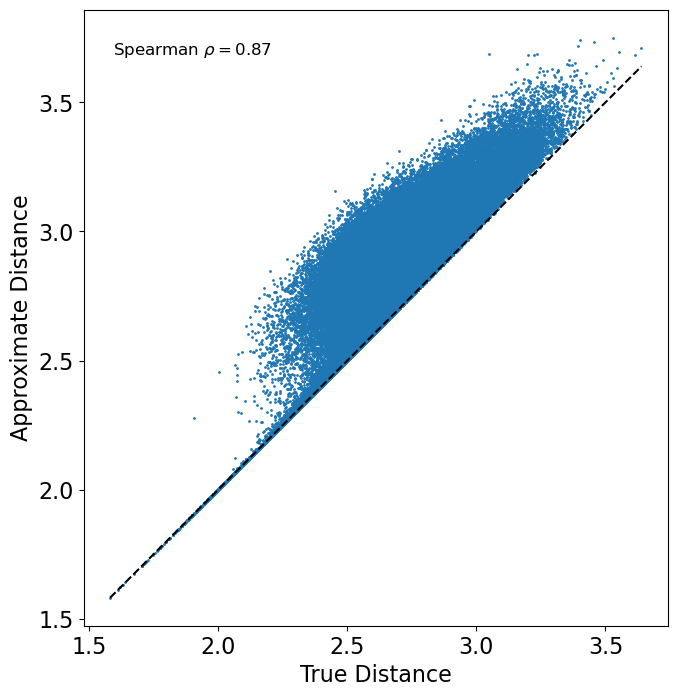

In [ ]:
from scipy.stats import spearmanr

# Calculate Spearman correlation
corr, _ = spearmanr(true_dists, approx_dists)

plt.figure(figsize=(8, 8))
plt.scatter(true_dists, approx_dists, s=1)
plt.plot([min(true_dists), max(true_dists)], [min(true_dists), max(true_dists)], 'k--')
plt.xlabel('True Distance')
plt.ylabel('Approximate Distance')
plt.gca().set_aspect('equal', adjustable='box')

# Display Spearman correlation in the corner
plt.text(0.05, 0.95, f'Spearman $\\rho ={corr:.2f}$', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.savefig("qm9_approx.png", dpi=300)

/tmp/ipykernel_3064142/340189280.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f"{i}" for i in range(1, 21)] + [">20"]);


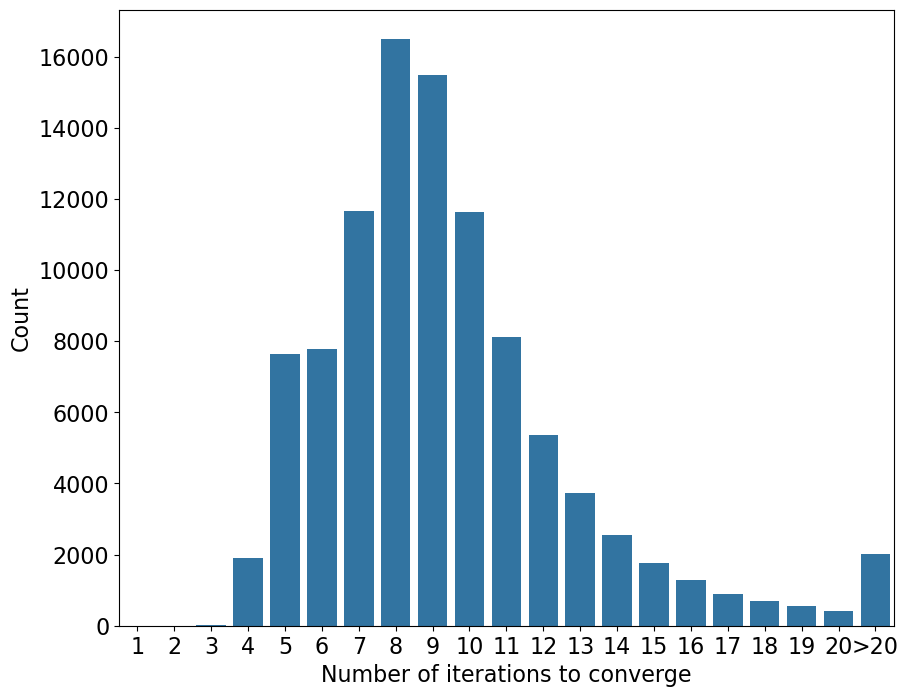

In [ ]:
plt.figure(figsize=(10, 8))

counts = []
for num_iter in range(1, 22):
    counts.append(np.sum(num_to_converge == num_iter))
sns.barplot(x=range(1, 22), y=counts)
plt.xlabel("Number of iterations to converge");
plt.ylabel("Count");
plt.gca().set_xticklabels([f"{i}" for i in range(1, 21)] + [">20"]);

plt.savefig("qm9_converge.png", dpi=300)

In [6]:
nonzero_errors = last_errors[num_to_converge == 21]
rate = len(nonzero_errors) / len(last_errors) * 100
print(f"About {rate:.2f}% of the time, the logarithm does not converge within 20 iterations.")
print(f"Median number of iterations to converge: {np.median(num_to_converge[num_to_converge < 21])}")
print(f"Median 1-iter error {np.median(one_iter_errors)}")
print(f"Mean error when it doesn't converge: {nonzero_errors.mean()}")
print(f"Max error when it doesn't converge: {nonzero_errors.max()}")
print(f"Median error when it doesn't converge: {np.median(nonzero_errors)}")
print(f"Min error when it doesn't converge: {nonzero_errors.min()}")

About 2.02% of the time, the logarithm does not converge within 20 iterations.
Median number of iterations to converge: 9.0
Median 1-iter error 0.9377650618553162
Mean error when it doesn't converge: 0.02825324982404709
Max error when it doesn't converge: 1.8812105655670166
Median error when it doesn't converge: 0.00025091320276260376
Min error when it doesn't converge: 8.547678589820862e-06


<Axes: ylabel='Count'>

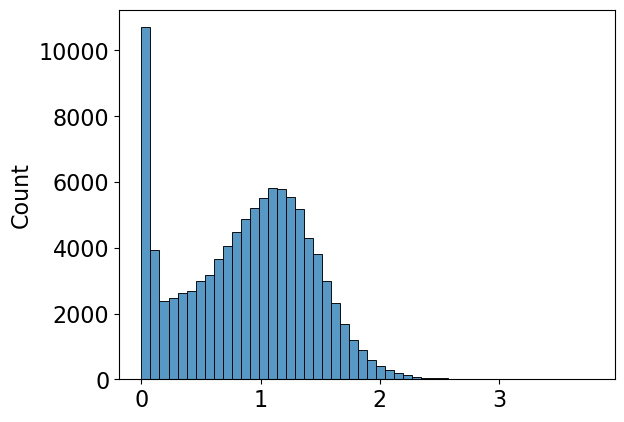

In [7]:
sns.histplot(one_iter_errors, bins=50)